# Health Insurance Cross Sell Prediction: Kaggle Competition Attempt

Below, I attempt the Health Insurance Cross Sell Prediction competition on Kaggle. In this competition, competitors are required to predict which health insurance policy holders from the previous year would be interetsed in vehicle insurance in the current year, based on a variety of measurements the insurance company has on these customers. Being able to predict the propensity of customers to take up a particular insurance policy is extremely useful for the insurance company as they are then able to better structure their communication strategy in order to achieve a high take up rate.

Let's begin by importing the necessary libraries.

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import plot_partial_dependence

import matplotlib.pyplot as plt

import lightgbm as lgb

Now, I read in the training dataset and peak at the head of the dataset.

In [2]:
# Read in the training dataset
cross_sell_df = pd.read_csv('train.csv')

In [3]:
# Examine the head of the training data
cross_sell_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


We can see that the ID column is simply an index column for the different clients and will thus provide no predictive power to a model. Therefore, we drop it and continue by ensuring all variables have the correct encoding.

In [4]:
# Drop the id column from the training set as it will be useless for propensity prediction
cross_sell_df.drop('id', axis=1, inplace=True)

# Code Region_Code and Policy_Sales_Channel as integer variables
cross_sell_df[['Region_Code', 'Policy_Sales_Channel']] = cross_sell_df[['Region_Code', 'Policy_Sales_Channel']].astype('int')

# Ensure all categorical and numeric variables are encoded correctly
cross_sell_df[['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']] = cross_sell_df[['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']].astype('category')

Next, we check for missing values.

In [5]:
# Determine the frequency of missing values per variable
cross_sell_df.isnull().sum()/cross_sell_df.shape[0]

Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

Here, we see that no variables contain missing values. Let's move on to checking the distribution of our response variable.

Number of cases: 46710
Number of controls: 334399
Percentage of controls is: 0.12256336113815208


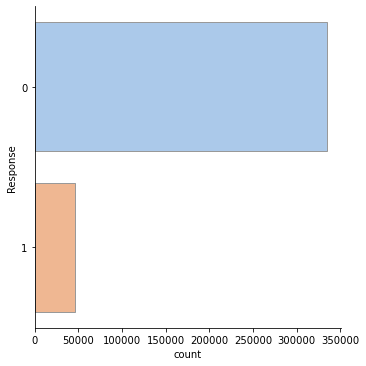

In [6]:
# Examine the how the response is balanced
sns.catplot(y="Response",kind="count",
            palette="pastel", edgecolor=".6",
            data=cross_sell_df)

# Determine the number of cases and controls respectively
print('Number of cases:', cross_sell_df[cross_sell_df['Response'] == 1].shape[0])
print('Number of controls:', cross_sell_df[cross_sell_df['Response'] == 0].shape[0])

# Determine the percentage of cases (1's) in the training set
case_perc = cross_sell_df[cross_sell_df['Response'] == 1].shape[0]/(cross_sell_df[cross_sell_df['Response'] == 0].shape[0] + cross_sell_df[cross_sell_df['Response'] == 1].shape[0])
print('Percentage of controls is:', case_perc)

From the above, we see that approximatley 12% of the clients in the training set were labelled as interested in vehicle insurance. Unfortunatley, any model we try to build will learn disproportionately more from the uninterested clients than from the interested ones, and we will end up with a model that will perform poorly on interested clients (as there is proportionally far less information on them in the training set than the uninterested clients). This problem is known as class imbalance. In order to build a model that is able to identify interested clients with high accuracy (perhaps at the expense of mislabelling some uninteretsed clients as interested), we need to account for this class imbalance. The data we have on hand shoud dictate which method we use to account for the class imbalance. 

Since we have 334 399 controls and 46 710 cases in the training set, I will begin by using random downsampling of the majority class as a method to address the class imbalance issue. I will try to obtain 40% cases in the training set

Another important point to raise is that of out-of-time (OOT) error estimation. If we artifically correct for the class imbalance issue (e.g. by randomly downsampling the majority class), we are creating an artificial environment that is different from what the model will see when in production. An out-of-time sample seeks to replicate production conditions, and obtaining the model's AUC on this set will give us an idea of how we can expect the model to perform in production. Therefore, I will split the training set into training, validation and out-of-time sets.

In [7]:
# Create the OOT sample, and training and validation samples
response = cross_sell_df.pop('Response')
X, X_oot, y, y_oot = train_test_split(cross_sell_df, response, test_size=0.1, random_state=1)

In [8]:
# Seperate the cases and controls
df = pd.concat([X, y], axis=1)

cases = df[y==1]
controls = df[y==0]

# Downsample the controls
controls = controls.sample(n=63174, random_state=1)

# Concatenate
train = pd.concat([cases, controls], axis=0)
y = train.pop('Response')

# Calculate the percentage of cases in the training set
case_perc = train[y == 1].shape[0]/(train[y == 0].shape[0] + train[y == 1].shape[0])
print('Percentage of controls is:', case_perc)

Percentage of controls is: 0.4


We have successfully downsampled to achieve 40% cases in the training set. Now, let's perform an exploratory data analysis on the training set features, starting with the categorical features. Let's take a look at Gender.

In [9]:
# Peak at the variable
train['Gender'].head(10)

232354      Male
135162      Male
226772      Male
279125      Male
153232      Male
211760      Male
94395       Male
196238      Male
183823    Female
330230    Female
Name: Gender, dtype: category
Categories (2, object): ['Female', 'Male']

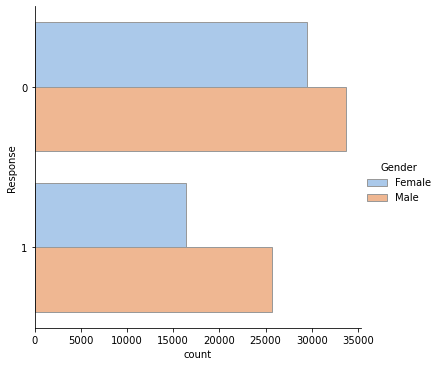

In [10]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y="Response", hue='Gender', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

There seems to be a slight difference in the distribution of the Gender variable between the two levels of the response. We also see that there are more males than females in the training set. Let's move on to Driving_License.

In [11]:
train['Driving_License'].head(10)

232354    1
135162    1
226772    1
279125    1
153232    1
211760    1
94395     1
196238    1
183823    1
330230    1
Name: Driving_License, dtype: category
Categories (2, int64): [0, 1]

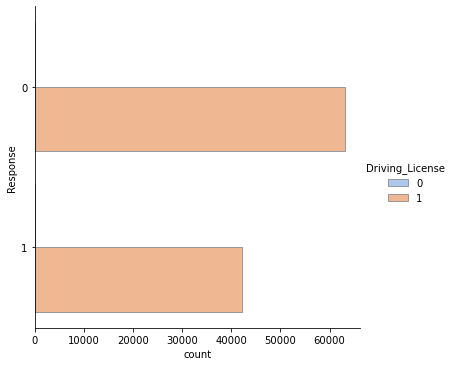

In [12]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y="Response", hue='Driving_License', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

This is concerning. We see that not a single observation in the training set does not have a drivers license. This immidiatley indicates that the Driving_License variable will contain no predictive power for any model we may choose to build. This fact will be confirmed later when we compute a concrete measure of predictive power using Weights of Evidence and Information Value. Let's move on to Region_Code.

In [13]:
train['Region_Code'].head(10)

232354    28
135162    31
226772    30
279125    13
153232    15
211760    28
94395     28
196238     3
183823    28
330230    41
Name: Region_Code, dtype: category
Categories (53, int64): [0, 1, 2, 3, ..., 49, 50, 51, 52]

We see that Region_Code has 53 levels which may make it challenging to visualise. However, it is important to confirm that the variable is adequatley balanced.

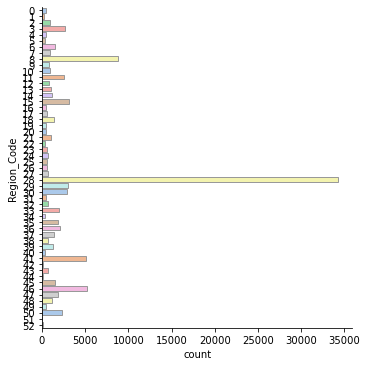

In [14]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y='Region_Code', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

We see that Regions 8 and 28 dominate the training sample. It will be interesting to see if this variable ends up being predictive, but my intuition says not as there are a few dominating categories. Let's see the percentage of observations in each category.

In [15]:
# Determine frequency distrubtion of Region_Code
train['Region_Code'].value_counts()/train['Region_Code'].shape[0]

28    0.324960
8     0.083427
46    0.049340
41    0.048181
15    0.029927
29    0.028654
30    0.027486
3     0.024960
11    0.024228
50    0.022291
36    0.020087
33    0.019100
35    0.018131
47    0.018055
6     0.014674
45    0.014446
18    0.013733
37    0.012850
39    0.012033
48    0.011416
14    0.011407
21    0.009783
13    0.009783
2     0.009213
10    0.009146
7     0.008928
12    0.007541
9     0.007408
32    0.007095
24    0.006582
43    0.006458
38    0.006297
27    0.006287
26    0.006116
17    0.005955
23    0.005746
25    0.005252
4     0.005072
20    0.004939
31    0.004749
0     0.004682
19    0.004473
16    0.004464
49    0.004369
34    0.003733
5     0.003410
40    0.003324
22    0.003011
1     0.002488
44    0.001691
42    0.001377
52    0.000712
51    0.000532
Name: Region_Code, dtype: float64

We see that Region 28 contains approximatley 32% of the observations in the training set. Let's move on to examining Previously_Insured.

In [16]:
# Peak at the variable
train['Previously_Insured'].head(10)

232354    0
135162    0
226772    0
279125    0
153232    0
211760    0
94395     0
196238    0
183823    0
330230    0
Name: Previously_Insured, dtype: category
Categories (2, int64): [0, 1]

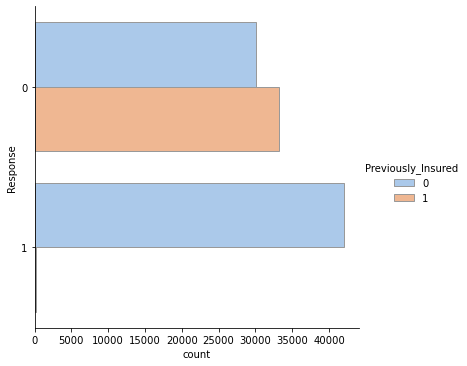

In [17]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y="Response", hue='Previously_Insured', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

In [18]:
# Determine frequency distrubtion of Previously_Insured for interested clients
train['Previously_Insured'][y==1].value_counts()/train['Previously_Insured'][y==1].shape[0]

0    0.996486
1    0.003514
Name: Previously_Insured, dtype: float64

Again, extremely interesting. This plot, with the accompanying frequency distribution, is telling us that for those clients labeled as interested in vehicle insurance in the training set, almost none of them had been previously insured. I would expect this variable to have strong predictive power. Let's move on to examining Vehicle_Age.

In [19]:
# Peak at the variable
train['Vehicle_Age'].head(10)

232354    < 1 Year
135162    1-2 Year
226772    1-2 Year
279125    1-2 Year
153232    1-2 Year
211760    1-2 Year
94395     1-2 Year
196238    < 1 Year
183823    < 1 Year
330230    1-2 Year
Name: Vehicle_Age, dtype: category
Categories (3, object): ['1-2 Year', '< 1 Year', '> 2 Years']

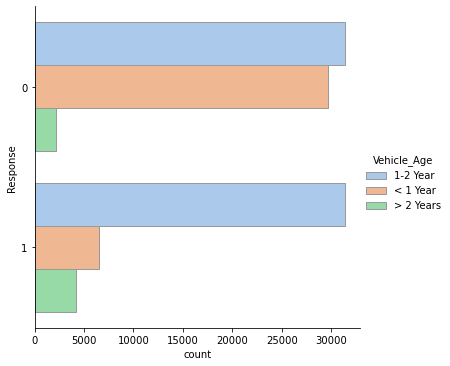

In [20]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y="Response", hue='Vehicle_Age', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

Most interestingly, clients with vehicles less than a year old are far less likely to be interested in vehicle insurance. Let's analyse Vehicle_Damage.

In [21]:
# Peak at the variable
train['Vehicle_Damage'].head(10)

232354    Yes
135162    Yes
226772    Yes
279125    Yes
153232    Yes
211760    Yes
94395     Yes
196238    Yes
183823    Yes
330230    Yes
Name: Vehicle_Damage, dtype: category
Categories (2, object): ['No', 'Yes']

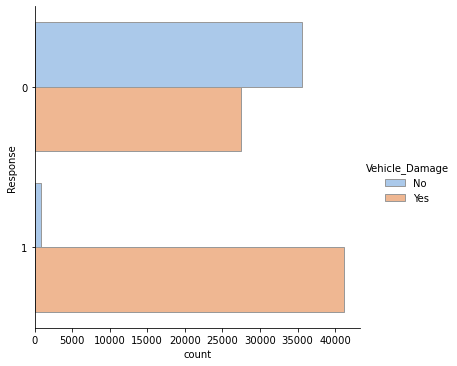

In [22]:
# Visualise the distribution of the input variable for each level of the response
sns.catplot(y="Response", hue='Vehicle_Damage', kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1))

Perhaps unsurprisingly, clients who are interested in vehicle insurance are far more likely to have had vehicle damage in the past than not. This could be because they have had experience with how much it truly costs to fix vehicle damage, and are thus far more likely to pay a premium for the transfer of that risk. I think this variable will contribute predictive power. Let's examine our last categorical feature, Policy_Sales_Channel.

In [23]:
# Peak at the variable
train['Policy_Sales_Channel'].head(10)

232354    124
135162    124
226772      4
279125     26
153232    124
211760     26
94395     124
196238    163
183823    152
330230    124
Name: Policy_Sales_Channel, dtype: category
Categories (155, int64): [1, 2, 3, 4, ..., 158, 159, 160, 163]

This variable has 163 categories making it near impossible to extract meaningful insights from a visualisation of the full variable. Let's check the frequency distribution of the variable.

In [24]:
# Determine frequency distrubtion of Policy_Sales_Channel
(train['Policy_Sales_Channel'].value_counts()/train['Policy_Sales_Channel'].shape[0])[:10]

152    0.266996
26     0.250869
124    0.228664
160    0.042046
156    0.034286
122    0.029775
157    0.024105
154    0.020790
163    0.011169
151    0.008063
Name: Policy_Sales_Channel, dtype: float64

We see that channels 152, 26, and 124 contain approximatley 75% of the observations in the training set. One strategy here may be to group the remaining categories into an 'Other' category. Let's note this as something that could lead to an increase in validation AUC and move on to the numeric features, beginning with Age.

In [25]:
# View some summary stats of variable
train['Age'].describe()

count    105290.000000
mean         40.311008
std          14.697755
min          20.000000
25%          26.000000
50%          40.000000
75%          50.000000
max          85.000000
Name: Age, dtype: float64

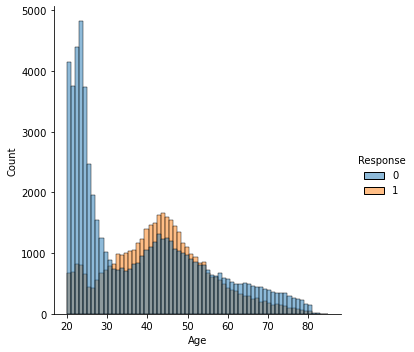

In [26]:
sns.displot(pd.concat([train, y], axis=1), x="Age", hue="Response")

In [27]:
train['Age'][y==1].describe()

count    42116.000000
mean        43.448214
std         12.166253
min         20.000000
25%         35.000000
50%         43.000000
75%         51.000000
max         83.000000
Name: Age, dtype: float64

In [28]:
train['Age'][y==0].describe()

count    63174.000000
mean        38.219537
std         15.824942
min         20.000000
25%         24.000000
50%         34.000000
75%         49.000000
max         85.000000
Name: Age, dtype: float64

Here is an interesting visualisation. We see that clients younger than appoximatley 30 years old are far more likely to be uninterested in vehicle insurance. This may be because younger clients are usually calculated to be a higher risk, and will thus be charged higher premiums. We also see that the peak of the histogram for interested clients is around 45 years. I think this variable will be useful in predicting propensity for vehicle insurance as the two distributions are different from one another. Let's go on to analyse 'Annual_Premium'.

In [29]:
# View some summary stats of variable
train['Annual_Premium'].describe()

count    105290.000000
mean      30936.625017
std       17643.130567
min        2630.000000
25%       24579.000000
50%       32085.500000
75%       40052.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

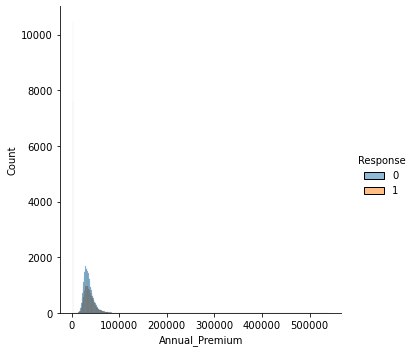

In [30]:
sns.displot(pd.concat([train, y], axis=1), x="Annual_Premium", hue="Response")

In [31]:
train[train['Annual_Premium'] <= 2630]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
135162,Male,39,1,31,0,1-2 Year,Yes,2630.0,124,254
978,Female,33,1,46,0,1-2 Year,Yes,2630.0,156,116
15456,Male,25,1,35,1,< 1 Year,No,2630.0,152,99
146514,Female,35,1,50,0,1-2 Year,Yes,2630.0,157,63
164881,Male,63,1,28,0,1-2 Year,Yes,2630.0,26,232
...,...,...,...,...,...,...,...,...,...,...
228432,Female,45,1,28,0,1-2 Year,No,2630.0,156,243
126828,Male,48,1,46,0,1-2 Year,Yes,2630.0,11,266
68101,Female,37,1,9,0,1-2 Year,Yes,2630.0,157,269
134547,Female,24,1,14,1,< 1 Year,No,2630.0,152,16


After a bit of digging, I found that 18116 clients (out of 105 290) have the minimum annual premium of Rs. 2630. All other clients have a significantly higher premium. This could be because this price point is a special product that many clients are purchasing. 

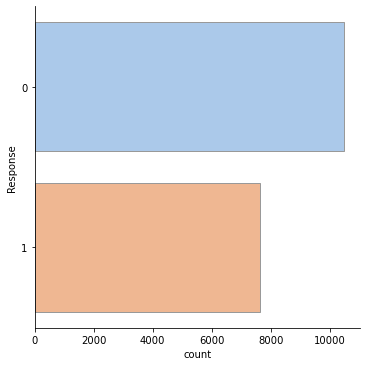

In [32]:
# Examine the distribution of the response for clients with an Annual_Premium of Rs. 2630
sns.catplot(y="Response", kind="count",
            palette="pastel", edgecolor=".6",
            data=pd.concat([train, y], axis=1)[pd.concat([train, y], axis=1)["Annual_Premium"] == 2630])

We see that the distribution of the response is fairly evenly distributed for clients paying an Annual_Premium of Rs. 2630.

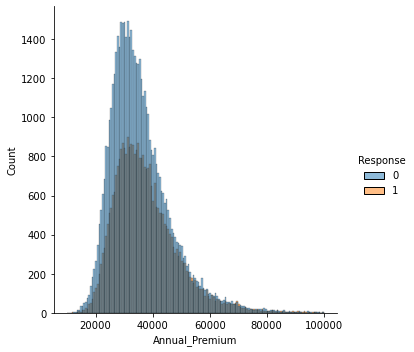

In [33]:
# Examine the distribution of Annual_Premium for the other clients
sns.displot(pd.concat([train, y], axis=1)[(pd.concat([train, y], axis=1)["Annual_Premium"] > 2630) & (pd.concat([train, y], axis=1)["Annual_Premium"] < 100000)], x="Annual_Premium", hue="Response")

Due to the presence of some gross outliers, I plot the ditribution of Annual_Premium for Annual_Premium less than Rs. 100 000 and greater than Rs. 2630. We see that of these clients, the distribution of this variable is similar in shape for the two levels of the response, indicating that uninterested and interested clients with an Annual_Premium less than Rs. 100 000 and greater than Rs. 2630 have a similar premium distribution. 

In [34]:
# View some summary stats of variable
train['Vintage'].describe()

count    105290.000000
mean        154.267005
std          83.711296
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

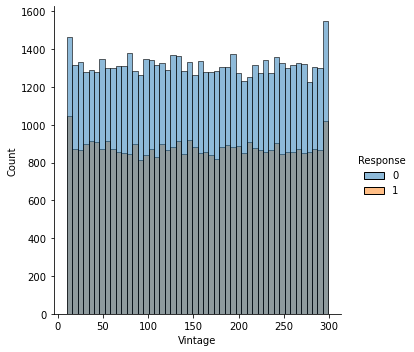

In [35]:
sns.displot(pd.concat([train, y], axis=1), x="Vintage", hue="Response")

This visualisation shows that at every Vintage, customers are more likely to be uninterested in vehicle insurance than interested. This is not a particularly useful result so I believe this variable will not be very useful in predicting insurance propensity.

Finally, let's examine the correlation matrix of the numeric predictors.

In [36]:
train[['Age', 'Annual_Premium', 'Vintage']].corr()

,Age,Annual_Premium,Vintage
Age,1.000000,0.086972,0.000809
Annual_Premium,0.086972,1.000000,0.000761
Vintage,0.000809,0.000761,1.000000


This is assuring. No numeric variables are substantially correlated with one another. Now, let's have a look at the information value of the categorical variables.

In [37]:
# Obtain the numerical representations of the categorical variables
cats = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
for i in range(len(cats)):
   train[cats[i]] = train[cats[i]].cat.codes

In [38]:
def iv_woe(data, target, cont_vars, bins=10, show_woe=False):
    """
    This function calculates the WoE and IV for each independnent variable in 
    data (categorical and continuous).

    Parameters
    ----------
    data : pandas DataFrame
        The dataset that will be used for machine learning (should include the target)
    target : string
        The name of the target variable.
    cont_vars : list
        A list of the continuous variables
    bins : int, optional
        The number of bins that continuoes variables should be split into. The default is 10.
    show_woe : boolean, optional
        Display the WoE dataframe. The default is False.

    Returns
    -------
    newDF : pandas DataFrame
        DataFrame containing the IV values per variable.
    woeDF : pandas DataFrame
        DataFrame containing the WoE values for each variable.

    """
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        
        # Check if the independent variable is continuous.
        if (ivars in cont_vars):
            
            # Bin the continuous variable according to the bins argument
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            
            # Append the response value to the binned version of x
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            
        else: 
            
            # Treat the variable as categorical
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        # Aggregate the response by count and sum per independent variable
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate the percentage of events in each group
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        
        # Calculate the percentage of non-events in each group
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        
        # Calculate WoE per category/bin
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        
        # Calculate information value and print it out
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        
        # Compose the WoE and IV tables
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
            
    return newDF, woeDF

In [39]:
iv, woe = iv_woe(pd.concat([train, y], axis=1), 'Response', cont_vars=['Age', 'Annual_Premium', 'Vintage'], bins=10, show_woe=False)

Information value of Gender is 0.024667
Information value of Age is 0.592401
Information value of Driving_License is 0.001264
Information value of Region_Code is 0.178313
Information value of Previously_Insured is 2.996098
Information value of Vehicle_Age is 0.524666
Information value of Vehicle_Damage is 2.215981
Information value of Annual_Premium is 0.026107
Information value of Policy_Sales_Channel is 0.842605
Information value of Vintage is 0.000374


Of the categorical variables, Vehicle_Age and Region_Code are strong predictors of insurance propensity by information value. We also see that Previously_Insured, Vehicle_Damage, and Policy_Sales_Channel have suspicioulsy high information values (>0.5). This may be indicative of data leakage. If we look back at the EDA we performed on these variables, we found plausable reasons to explain why the distributions of these variables looked so different for the two levels of the response. Usually, I would try and fit a model without these suspiciously strong predictors as I am weary of data leakage possibilities, but since this is a Kaggle competition and we are only interested in high AUC, I will keep them.

As expected, Driving_License has very low information value and should be dropped from further analysis.

In [40]:
train.drop('Driving_License', axis=1, inplace=True)

Let's go on to contructing the training and validation sets.

In [41]:
# Create the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.25, random_state=1)

Now, we can move on to fitting our first model. As a baseline, I will use a decision tree classifier.

In [42]:
# Create and fit the decision tree classifier with defualt values
clf_dectree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [43]:
# Compute the valdiation set AUC of the baseline model
roc_auc_score(y_true=y_val, y_score=clf_dectree.predict_proba(X_val)[:,1])

0.6946460237814933

We see that the baseline model achieves a validation set AUC of approximatley 0.69. I think we can definitley fit a better model. Let's see if we can tune the cost complexity parameter of the tree in order to achieve a higher validation set AUC.

In [44]:
# Tune the cost complexity parameter of the decision tree
alpha = np.arange(0, 0.001, 0.0001)

val_auc = [0]*len(alpha)
for i in range(0, len(alpha)):
    clf_dectree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha[i]).fit(X_train, y_train)
    val_auc[i] = roc_auc_score(y_true=y_val, y_score=clf_dectree.predict_proba(X_val)[:,1])

In [45]:
# Visualise results
pd.DataFrame({"Alpha":alpha, "AUC":val_auc})

,Alpha,AUC
0,0.0000,0.694646
1,0.0001,0.845304
2,0.0002,0.844230
3,0.0003,0.841830
4,0.0004,0.834972
5,0.0005,0.834972
6,0.0006,0.830651
7,0.0007,0.829603
8,0.0008,0.829603
9,0.0009,0.829603


We see that a value for $\alpha$ of 0.0001 leads to a validation set AUC of 0.845304. Let's see if we can improve on this with a random forest of decision trees.

In [46]:
# Fit a baseline random forest
clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5,
        min_samples_leaf=20, random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, min_samples_leaf=20, n_estimators=40,
                       n_jobs=-1, random_state=0)

In [47]:
# Calculate the validation set AUC
roc_auc_score(y_true=y_val, y_score=clf_rf.predict_proba(X_val)[:,1])

0.8481042556088161

We see that an untuned random forest has a validation set AUC of 0.8481. Let's see if we can improve on this by tuning max_features.

In [48]:
# Tune max_features
max_features = np.arange(1, len(X_train.columns))

val_auc = [0]*len(max_features)
for i in range(0, len(max_features)):
    clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=max_features[i],
        min_samples_leaf=20, random_state=0).fit(X_train, y_train)
    val_auc[i] = roc_auc_score(y_true=y_val, y_score=clf_rf.predict_proba(X_val)[:,1])

In [49]:
# Visualise results
pd.DataFrame({"max_features":max_features, "AUC":val_auc})

,max_features,AUC
0,1,0.848956
1,2,0.849257
2,3,0.848979
3,4,0.848104
4,5,0.846847
5,6,0.846519
6,7,0.846346
7,8,0.846046


We see that setting max_featuresequal to 2 provides maximum validation set AUC. Let's go on to examine feature importence of our input features.

In [50]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

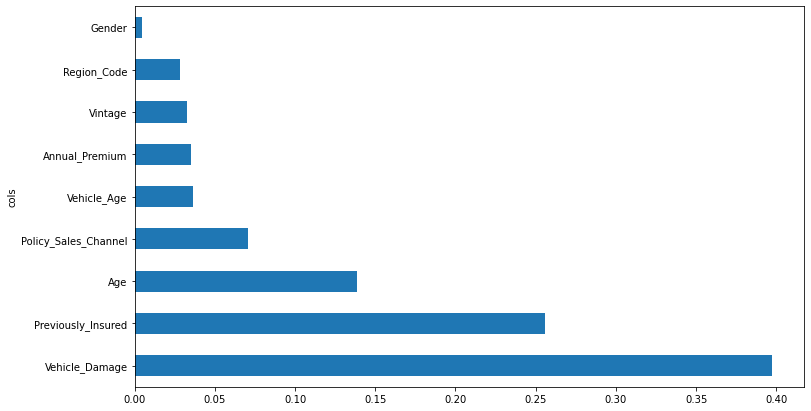

In [51]:
# Train the tuned random forest classifier
clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=2,
        min_samples_leaf=20, random_state=0).fit(X_train, y_train)

# Generate feature importance plot
fi = rf_feat_importance(clf_rf, X_train)
plot_fi(fi)

The above feature importance plot tells us that Vehicle_Damage, Previously_Insured, and Age are the most important features in predicting propensity for vehicle insurance. From our EDA, this result is not surprising. For example, we saw that almost all customers labelled as interested had experienced vehicle damage in the past, whereas uninterested customers were slightly more likely to have experienced no past vehicle damage. Does it make sense to recommend vehicle insurance based on this fact? Should we recommend insurance to customers that could be considered more risky? This is out of the scope of this competition but it is an interesting thought. 

Let's move on to examining some partial dependence plots of our numerical inputs to gauge whether they have the relationship with the response that we would expect.

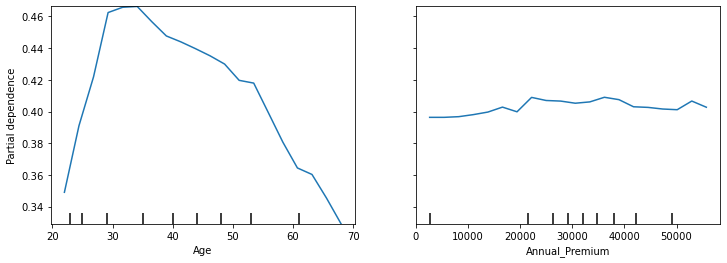

In [52]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(clf_rf, X_val, ['Age','Annual_Premium'],
                        grid_resolution=20, ax=ax);

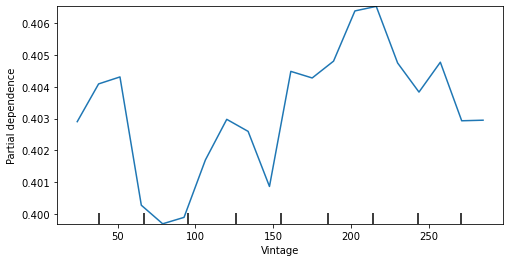

In [53]:
fig,ax = plt.subplots(figsize=(8, 4))
plot_partial_dependence(clf_rf, X_val, ['Vintage'],
                        grid_resolution=20, ax=ax);

Here, we see that the random forest has learnt a unimodal relationship between Age and predicted probability of being interested in a vehicle insurance policy. Clients between 30 and 40 years of age seem to be most likely to be interetsed in vehicle insurance (this is consistent with the empirical distribution of age that I plotted earlier). 

Furthermore, we see that the model has not learnt a clear relationship between Annual_Premium and the predicted probability of being interested in a vehicle insurance policy. This is reflected in this variable's low feature importance score. However, we saw earlier that a high proportion of clients have Annual_Premiums equal to the minimum value of Rs. 2630. Perhaps building two seperate models, one to treat the Rs. 2630 clients, and one to treat all others, may lead to an improvement in test AUC. For now, I am going to pin this idea for the sake of article length.

Lastly, there appear to be regions of the domain of Vinatge where clients are more likely to be interested in vehicle insurance according to the random forest model. For example, clients with a vintage of between approximatley 75 and 100 months are least likely to be interested in vehicle insurance, while clients with a vintage of between approximatley 200 and 210 months are most likely to want vehicle insurance. There was no indication of this pattern in the exploratory data analysis, so I am hesitant to attach too much meaning to this finding.

Finally, let's go on to test a LightGBM model.

In [54]:
# Create the training and sets
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_val, label=y_val)

In [55]:
# Train a LightGBM model with default values
parameters = {'objective' : 'binary',
              'metric' : 'auc',
              'seed' : 1,
              'verbose' : 0}
bst = lgb.train(parameters, train_data, valid_sets=[validation_data], verbose_eval=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [56]:
# Calculate the validation set AUC
roc_auc_score(y_true=y_val, y_score=bst.predict(X_val))

0.8536486788387558

The LightGBM classifier has a validation set AUC of 0.8536, slightly better than the random forest. Let's see if we can improve on this result by implementing hyperparameter tuning for the learning rate and the max depth of each tree, and utiltising early stopping.

In [57]:
# Create the parameter grid
max_depth = np.arange(1, 11)
learning_rate = np.arange(0.01, 0.11, 0.01)
param_grid = [(x, y) for x in max_depth for y in learning_rate]

# Create the lists to hold the validation set AUC scores and early stopping iterations
val_auc = [0]*len(param_grid)
boosting_iterations = [0]*len(param_grid)

In [58]:
# Perform hyperparameter tuning
for i in range(0, len(param_grid)):
    
    # Create the parameter dict
    parameters = {
                    'objective': 'binary',
                    'metric': 'auc',
                    'max_depth': param_grid[i][0],
                    'learning_rate': param_grid[i][1],
                    'verbose' : -1,
                    'seed' : 1
                }
    
    # Train the classifier
    bst = lgb.train(parameters, train_data, valid_sets=[validation_data], num_boost_round=5000, early_stopping_rounds=100, 
                    verbose_eval=False)
    
    # Calculate the validation set AUC
    val_auc[i] = roc_auc_score(y_true=y_val, y_score=bst.predict(X_val, num_iteration=bst.best_iteration))
    boosting_iterations[i] = bst.best_iteration

In [59]:
# Examine which parameter values led to the highest validation set AUC
print("Max validation set AUC:", val_auc[np.where(val_auc == np.max(val_auc))[0][0]])
print("Optimal paramater values:", param_grid[np.where(val_auc == np.max(val_auc))[0][0]])
print("Optimal boosting iterations:", boosting_iterations[np.where(val_auc == np.max(val_auc))[0][0]])

Max validation set AUC: 0.8544605311928813
Optimal paramater values: (2, 0.09)
Optimal boosting iterations: 891


We see that the optimal LightGBM model has a validation set AUC of 0.8545. Now, let's examine feature importance.

In [60]:
# Train the optimal model
parameters = {
                'objective': 'binary',
                'metric': 'auc',
                'max_depth': 2,
                'learning_rate': 0.09,
                'verbose' : -1,
                'seed' : 1
                }
bst = lgb.train(parameters, train_data, valid_sets=[validation_data], num_boost_round=1500, early_stopping_rounds=100, 
                verbose_eval=False)

In [61]:
def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importance()}
                       ).sort_values('imp', ascending=False)

<AxesSubplot:ylabel='cols'>

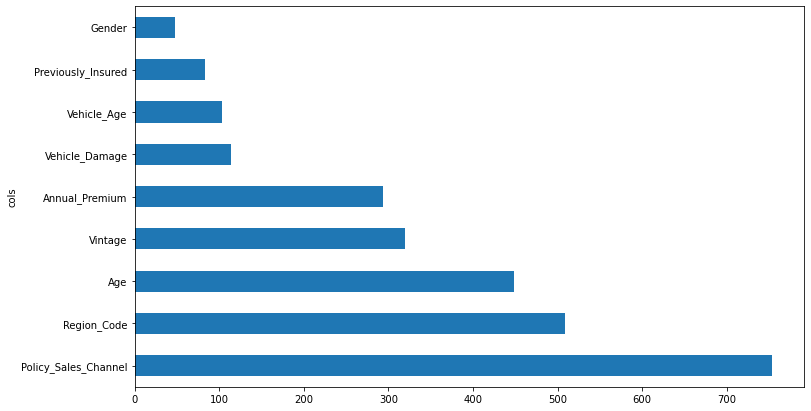

In [62]:
fi = lgb_feat_importance(bst, X_val)
plot_fi(fi)

This is interesting. The optimal LightGBM classifier has a fairly different ordering of the inputs in terms of feature importance than the optimal random forest. Let's examine the partial dependence plots of the two most important numerical predictors.

In [63]:
# Use the sklearn API to train the classifier
bst_sk = lgb.LGBMClassifier(objective='binary', max_depth=2, learning_rate=0.09,  random_state=1,n_estimators=1500)

bst_sk.fit(X_train, y_train, verbose=False, 
        early_stopping_rounds=100, eval_set=[(X_val, y_val)], eval_metric='auc')

LGBMClassifier(learning_rate=0.09, max_depth=2, n_estimators=1500,
               objective='binary', random_state=1)

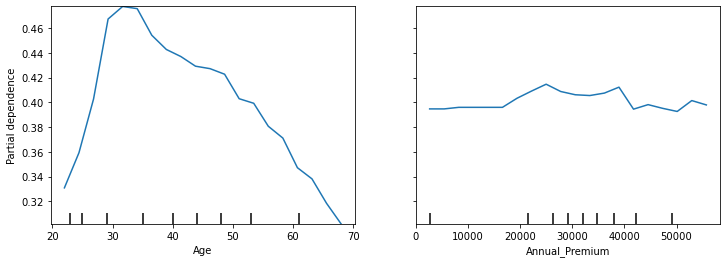

In [64]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(bst_sk, X_val, ['Age','Annual_Premium'],
                        grid_resolution=20, ax=ax);

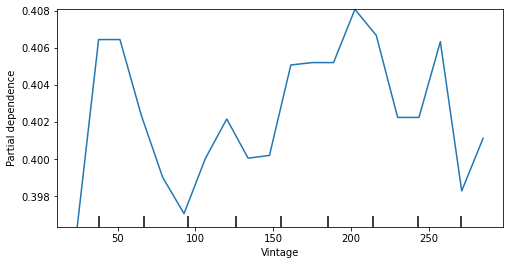

In [65]:
fig,ax = plt.subplots(figsize=(8, 4))
plot_partial_dependence(bst_sk, X_val, ['Vintage'],
                        grid_resolution=20, ax=ax);

It seems that the optimal LightGBM model has identified similar marginal relationships between the numerical inputs and the response to the optimal random forest model. 

Let's see how the validation set AUC is impacted if we remove the least important predictors.

In [66]:
# Select the most important features
to_keep = fi[fi.imp>100].cols
len(to_keep)

7

In [67]:
X_train_imp = X_train[to_keep]
X_val_imp = X_val[to_keep]

# Create the LightGBM training and validation sets
train_data = lgb.Dataset(X_train_imp , label=y_train)
validation_data = lbg.Dataset(X_val_imp, label=y_val)

NameError: name 'lbg' is not defined

In [ ]:
# Train the optimal model
parameters = {
                'objective': 'binary',
                'metric': 'auc',
                'max_depth': 2,
                'learning_rate': 0.09,
                'verbose' : -1,
                'seed' : 1
                }
bst = lgb.train(parameters, train_data, valid_sets=[validation_data], num_boost_round=1500, early_stopping_rounds=100, 
                verbose_eval=False)

In [ ]:
roc_auc_score(y_true=y_val, y_score=bst.predict(X_val_imp, num_iteration=bst.best_iteration))

We see that dropping Gender and Previously_Insured leads to a minisule reduction in validation set AUC.

Now, the last thing I would like to try is to see if using an ensemble of the optimal decision tree, random forest and LightGBM models will lead to a higher validation set AUC. My rationale here is that we would expect that the errors made by each learning method are relatively uncorrelated, and the average of their predictions should have lower error than either of the learning method's predictions in isolation. Let's test this hypothesis.

In [ ]:
# Train the tuned decision tree classifier on the training set selected by the LightGBM model
clf_dectree = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001).fit(X_train_imp, y_train)

# Train the tuned random forest classifier on the training set selected by the LightGBM model
clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=2,
        min_samples_leaf=20, random_state=0).fit(X_train_imp, y_train)

# Obtain the average prediction made by the ensemble of the random forest and LightGBM models
rf_preds = np.array(clf_rf.predict_proba(X_val_imp)[:,1])
light_preds = np.array(bst.predict(X_val_imp, num_iteration=bst.best_iteration))
dec_tree_preds = np.array(clf_dectree.predict_proba(X_val_imp)[:,1])
ensemble_preds = (rf_preds + light_preds + dec_tree_preds)/3

# Calculate the validation AUCs
print("Validation set AUC of the Decision Tree:", roc_auc_score(y_true=y_val, y_score=dec_tree_preds))
print("Validation set AUC of the Random Forest:", roc_auc_score(y_true=y_val, y_score=rf_preds))
print("Validation set AUC of the LightGBM:", roc_auc_score(y_true=y_val, y_score=light_preds))
print("Validation set AUC of the Ensemble:", roc_auc_score(y_true=y_val, y_score=ensemble_preds))

We see that we end on a marginally lower validation set AUC than the LightGBM model if we use the ensemble. It seems that here, the ensemble validation set AUC is weighed down by the random forest and decision tree. Furthermore, we may expect tree based methods to make predictions in a somewhat similar fashion, and thus their errors may be positivley correlated. Perhaps the inclusion of a method such as logistic regression or a support vector machine may have led to a different result.

I will be selecting the optimal LightGBM model as the model I will use on the test set. Let's examine what the out-of-sample AUC is for this model.

In [ ]:
# Prep the OOT set for prediction
# Obtain the numerical representations of the categorical variables
cats = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
for i in range(len(cats)):
   X_oot[cats[i]] = X_oot[cats[i]].cat.codes

X_oot_imp = X_oot[to_keep]

In [ ]:
# Combine the training and validation set to train on
X_train_final = pd.concat([X_train_imp, X_val_imp], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

# Create the LightGBM training and validation sets
train_data = lgb.Dataset(X_train_final , label=y_train_final)

# Train the optimal model
parameters = {
                'objective': 'binary',
                'max_depth': 2,
                'learning_rate': 0.09,
                'verbose' : -1,
                'seed' : 1
             }
bst = lgb.train(parameters, train_data, num_boost_round=891)

roc_auc_score(y_true=y_oot, y_score=bst.predict(X_oot_imp))

That is excellent! Usually, a degredation in AUC is expected when the case-to-control ratio returns to its original level. However, it seems that the increase in training data has outweighed this tendancy.

Now, let's obtain preditions on the test set.

In [ ]:
# Import the test set
test_set = pd.read_csv('test.csv')

# Prep the test set for prediction
ids = test_set.pop('id')

# Prep the OOT set for prediction
# Obtain the numerical representations of the categorical variables
cats = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']

test_set[cats] = test_set[cats].astype('category')

for i in range(len(cats)):
   test_set[cats[i]] = test_set[cats[i]].cat.codes

test_set_imp = test_set[to_keep]

In [ ]:
# Obtain predictions
preds = bst.predict(test_set_imp)

In [ ]:
# Write predictions to a CSV
pd.DataFrame({'id':ids, 'Response':preds}).to_csv('preds.csv')